**Load Dataset CIFAR-10**

In [ ]:
import torch
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

train_data = torchvision.datasets.CIFAR10(root="./",
                                      download=True,
                                      train=True,
                                      transform=transform
                                      )

test_data = torchvision.datasets.CIFAR10(root="./",
                                     download=True,
                                     train=False,
                                     transform=transform
                                     )

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


**Load Batches**

In [ ]:
batch_size = 128 # Batch size

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True
                                           )

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False
                                          )

**Designing The Model**

In [ ]:
from torch import nn
from collections import OrderedDict

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            # Input: 32x32x3
            ["Convl1",nn.Conv2d(3, 32, 3, 1, 1)], # Output: 32x32x32
            ["Relu1", nn.ReLU()],
            ["Convl2", nn.Conv2d(32, 64, 3, 1, 1)], # Output: 32x32x64
            ["Relu2", nn.ReLU()],
            ["Pool1", nn.MaxPool2d(2, 2)], # Output: 16x16x64
            ["drop1",nn.Dropout(0.25)],

            ["Convl3", nn.Conv2d(64, 128, 3, 1,1)], # Output: 16x16x128
            ["Relu3", nn.ReLU()],
            ["Convl4", nn.Conv2d(128, 256, 3, 1,1)], # Output: 32x32x256
            ["Relu4", nn.ReLU()],
            ["Pool2", nn.MaxPool2d(4)], # Output: 4x4x256
            ["drop2",nn.Dropout(0.25)],

            ["flatten",nn.Flatten()],
            ["lin1",nn.Linear(4*4*256, 128)],
            ["Relu5", nn.ReLU()],
            ["lin2", nn.Linear(128, 10)],
            ["output", nn.LogSoftmax(dim=1)]
        ]))

    def forward(self, x):
        """"""
        return self.layers(x)

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

#optimizer utility function
def train_model(model: torch.nn,
                data_loader,
                device,
                eta: float =0.001,
                epoch: int = 5,
                loss_fn = nn.CrossEntropyLoss()):
    """
    :param model: model definition
    :type model: torch.nn
    :param X: feature vector
    :type X: torch.tensor
    :param y: label vector
    :type y: torch.tensor
    :param eta: learning rate
    :type eta: float
    :param loss_fn: loss function
    :type loss_fn: callable
    :returns: None
    """
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    losses = []

    for epoch in (p := tqdm(range(epoch))):
        losses.append(0)
        for idx, (input, labels) in enumerate(data_loader):
            p.set_description(f"Loss in epoch {epoch}({idx}): {losses[-1] / (idx+1) if losses else 0}")
            optimizer.zero_grad()
            outputs = model(input.to(device))
            loss = loss_fn(outputs,labels.to(device))
            loss.backward()
            losses[-1] += float(loss.to("cpu"))
            optimizer.step()

        p.set_description(f"Loss in epoch {epoch}: {losses[-1]}")

    plt.plot(losses)
    plt.title("Loss / epoch")


**Train The Model**

Loss in epoch 4: 227.14639446139336: 100%|██████████| 5/5 [01:54<00:00, 23.00s/it]


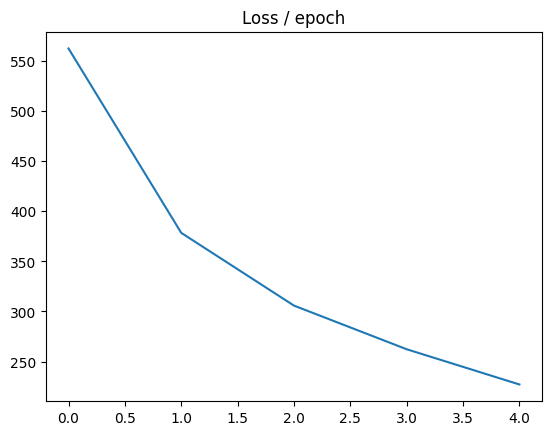

In [ ]:
device = "cuda"
cnn = CNN().to(device)

train_model(cnn, train_loader, device)

**Test The Model**

In [ ]:
#test function
def test_model(model: torch.nn,
               data_loader,
               device,
               loss_fn = nn.CrossEntropyLoss()
               ):
    """"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

test_model(cnn, test_loader, device)


Test set: Average loss: 0.0050, Accuracy: 7811/10000 (78%)



**Main effort put to achieve the targeted error rate**

---

To achieve the targeted error rate, the main efforts were focused on adjusting the convolutional architecture. This consisted of experimenting with the number and order of layers, adjusting the input and output sizes of convolution layers, tuning dropout rates, and changing the placement and sizes of pooling and dropout layers.